In [1]:
from utils import datasets
from utils.parser import * 
import os 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf 
from models import * 
from utilities import *
from train_model_utilities import * 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
dataset_name = 'seq_FUN'
train, valid, test = initialize_dataset(dataset_name, datasets)

scalar = StandardScaler().fit(train.X)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean').fit(train.X)
train.X = scalar.transform(imputer.transform(train.X))
valid.X = scalar.transform(imputer.transform(valid.X))
test.X = scalar.transform(imputer.transform(test.X))

train.Y = tf.convert_to_tensor(train.Y, tf.float32)
valid.Y = tf.convert_to_tensor(valid.Y, tf.float32)
test.Y = tf.convert_to_tensor(test.Y, tf.float32)

In [3]:
train_data = tf.data.Dataset.from_tensor_slices(
    (train.X, train.Y)
).shuffle(buffer_size = train.X.shape[0]).batch(batch_size=4)

In [4]:
def get_structure_from_adajancency(adajancency):
    structure = np.zeros(adajancency.shape)
    g = nx.DiGraph(adajancency) # train.A is the matrix where the direct connections are stored 
    for i in range(len(adajancency)):
        ancestors = list(nx.descendants(g, i)) #here we need to use the function nx.descendants() because in the directed graph the edges have source from the descendant and point towards the ancestor 
        if ancestors:
            structure[i, ancestors] = 1
    return structure 

AU(PRC) 
train: 0.9940987088099398, validation 0.3334440185174692, test 0.337960935833137


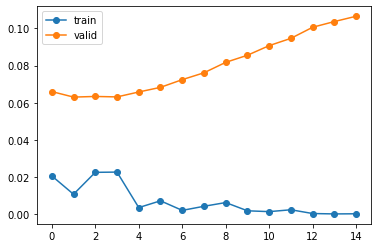

In [5]:
structure = get_structure_from_adajancency(train.A)
model = HMCModel(structure, 500, [2000,2000], 0.7)
loss_fn = get_loss_fn_coherent(structure)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5)
train_loss_list, valid_loss_list, train_score_list, valid_score_list, test_score_list = train_epoch(model, 
            optimizer, loss_fn, 'coherent_hmc', 15, 
            train_data, train.X, train.Y, valid.X, valid.Y, test.X, test.Y)

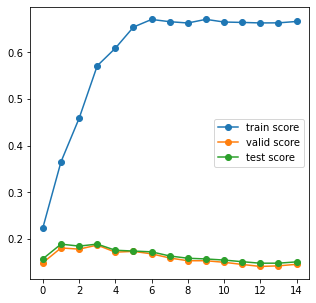

In [6]:
plt.figure(figsize=(5,5))
plt.plot(train_score_list, '-o', label='train score')
plt.plot(valid_score_list, '-o', label = 'valid score')
plt.plot(test_score_list, '-o', label = 'test score')
plt.legend()

In [10]:
logits = model(test.X)
logits = model.postprocess(logits)
prob = model.get_prob(logits)
custom_score(test.Y, model.predict(test.X))

0.15106186262702276

In [11]:
prob

<tf.Tensor: shape=(1339, 500), dtype=float32, numpy=
array([[2.9274819e-03, 6.9616726e-03, 1.3487568e-02, ..., 1.6498346e-08,
        1.5502108e-07, 1.7541910e-06],
       [4.0522167e-03, 2.0284110e-01, 1.7823813e-02, ..., 3.7495150e-07,
        3.4084488e-07, 8.3886139e-04],
       [1.6169591e-02, 6.7902142e-01, 6.3511826e-02, ..., 1.6487986e-07,
        2.9391441e-07, 8.0749788e-04],
       ...,
       [2.8028324e-02, 5.1613770e-06, 1.6290769e-03, ..., 4.2978985e-11,
        4.1114395e-10, 3.8332448e-08],
       [1.9907191e-02, 1.7551081e-02, 2.3608960e-03, ..., 5.1244888e-06,
        3.5098867e-07, 3.7996790e-05],
       [6.0078660e-03, 3.6258542e-04, 1.3244749e-03, ..., 6.7528860e-10,
        1.4124309e-07, 1.9289367e-08]], dtype=float32)>

In [12]:
model.predict(test.X)

<tf.Tensor: shape=(1339, 500), dtype=float32, numpy=
array([[1.8389150e-05, 4.9675011e-05, 6.4967853e-06, ..., 1.6498346e-08,
        1.5502108e-07, 1.7541910e-06],
       [4.9867147e-05, 1.3364156e-02, 7.0661696e-04, ..., 3.7495150e-07,
        3.4084488e-07, 8.3886139e-04],
       [1.0290087e-04, 3.2345413e-03, 3.1780419e-05, ..., 1.6487986e-07,
        2.9391441e-07, 8.0749788e-04],
       ...,
       [2.8028324e-02, 5.1613770e-06, 7.2344504e-09, ..., 4.2978985e-11,
        4.1114395e-10, 3.8332448e-08],
       [6.6523328e-03, 5.6834570e-03, 1.3532581e-04, ..., 5.1244888e-06,
        3.5098867e-07, 3.7996790e-05],
       [3.5588713e-05, 1.7876877e-06, 1.6871762e-07, ..., 6.7528860e-10,
        1.4124309e-07, 1.9289367e-08]], dtype=float32)>